## The problem

The flux of an isolated object calculated from its unacheviably idealistic image $I(\vec{x})$ is

$F = \int\int dx dy W(\vec{x}) I(\vec{x})$

for some choice of $W(\vec{x})$. The common choices are:

- Unweighted flux: $W(\vec{x}) \equiv 1$ everywhere

- Aperture flux: $W(\vec{x}) = 1 $ if $ \vec{x} \in A $ else 0.

- Gaussian flux: $W(\vec{x}) = \mathcal{N}(0, \bf{C})$. 


Given a pixelized image of $I(\vec{x})$, an estimate $\hat{F}$ of the flux $F$ must be linearly related to the pixel values $\{ I[m,n] \}_{m,n}$. The general expression for $\hat{F}$  is therefore an inner product of the pixel values with a pre-determined vector of same dimensions. The naive estimator of flux is then 

$\hat{F} = \sum_{m,n} W[m,n] I[m,n]$, where $\{ W[m,n] \}_{m,n}$ are $W(\vec{x})$ sampled at pixel centers.


The question we try to answer in this notebook is if this estimator is good enough, or should we do something more sophisiticated, as in Bickerton & Lupton (2013).


## Methodology

To answer this question, we will consider the simplest case $I(\vec{x}) = W(\vec{x}) = \mathcal{N}(\vec{x}_c, \sigma^2\mathbf{I})$. The expected flux for normalized Gaussian is $1/4\pi \sigma^2$. So we will scale $\hat{F}$ by the denominator to factor out the trivial, well-understood $\sigma$-dependence.

   In the continuous case, there are no hard boundaries (in principle) and the integration runs from $-\infty$ to $\infty$ in either directions. For any random sub-pixel offset $\vec{x}_o$, $F$ is invariant if both $W$ and $I$ shifted by $\vec{x}_o$, i.e.,
$F(\vec{x}_o) = \int\int dx dy W(\vec{x}-\vec{x}_o) I(\vec{x}-\vec{x}_o)$ should be independent of $\vec{x}_o$. However, it is not immediately clear if this holds true for $\hat{F}$ estimated from discrete images. A study of the sensitivity to such sub-pixel offsets will demonstrate the performance and robustness of our estimators.

In [2]:
## Do the imports
import numpy
import numpy as np
import os, sys
import scipy.special as special

import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['legend.fontsize']=14
matplotlib.rcParams['legend.numpoints']=1
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['legend.handlelength']=0.
matplotlib.rcParams['xtick.minor.visible']=True
matplotlib.rcParams['ytick.minor.visible']=True
matplotlib.rcParams['ytick.direction']='inout'
matplotlib.rcParams['xtick.direction']='inout'
if matplotlib.rcParams['xtick.direction']=='inout':
    matplotlib.rcParams['xtick.major.size']=2.*matplotlib.rcParams['xtick.major.size']
    matplotlib.rcParams['xtick.minor.size']=2.*matplotlib.rcParams['xtick.minor.size']
if matplotlib.rcParams['ytick.direction']=='inout':
    matplotlib.rcParams['ytick.major.size']=2.*matplotlib.rcParams['ytick.major.size']
    matplotlib.rcParams['ytick.minor.size']=2.*matplotlib.rcParams['ytick.minor.size']
matplotlib.rcParams['figure.subplot.bottom']=0.1
matplotlib.rcParams['figure.subplot.top']=0.95
matplotlib.rcParams['figure.subplot.right']=0.95
matplotlib.rcParams['figure.subplot.left']=0.095
matplotlib.rcParams['axes.labelsize']=18
matplotlib.rc('font',size=18)

In [4]:
def gaussianImage(n, center_x, center_y, sigma, theta=0., ellipticity=0.):
    image = numpy.zeros([n, n], dtype=float)
    cosT, sinT = numpy.cos(theta), -numpy.sin(theta)
    scale = 1.0 - ellipticity
    for ix in range(n):
        for iy in range(n):
            x, y = ix - center_x, iy - center_y
            xr, yr = x*cosT + y*sinT, scale*(-x*sinT + y*cosT)
            r2 = xr**2 + yr**2
            A = 1.0/(2.0*numpy.pi*sigma**2)
            image[iy,ix] = A*numpy.exp(-(r2)/(2.0*sigma**2))

    return image

def phaseImage(n , delta_x, delta_y):
    image = numpy.zeros([n,n], dtype=complex)
    center_x, center_y = (n+1)//2, (n+1)//2
    wid = n
    for iy in range(n):
        ky = float(iy-center_y)/wid
        for ix in range(n):
            kx = float(ix - center_x)/wid
            
            image[iy,ix] = numpy.exp(-1.0j*2*numpy.pi*(delta_x*kx+delta_y*ky))
            
    return image

In [5]:
## Code from Bickerton & Lupton (2013) modified for a Gaussian aperture

def gijCoefficients(n, x, y, sigma, theta, ellipticity):
    wid, xcen, ycen = n, (n+1)//2, (n+1)//2 ## integer division, works with python2 and 3
    dx, dy = x - xcen, y - ycen
    if n%2:
        dx, dy = dx + 1, dy + 1
    ftWij = numpy.zeros([wid, wid], dtype=complex)
    scale = 1.0 - ellipticity
    
    for iy in range(wid):
        ky = float(iy - ycen)/wid
        for ix in range(wid):
            kx = float(ix - xcen)/wid

            cosT, sinT = numpy.cos(theta), numpy.sin(theta)
            kxr, kyr = kx*cosT + ky*sinT, scale*(-kx*sinT + ky*cosT)
            k = sigma*numpy.sqrt(kxr**2 + kyr**2)
            
            # compute the Gaussian term, and apply shift theorem
            expo = -2.0*(numpy.pi*k)**2
            gauss = numpy.exp(expo)
            phase = numpy.exp(-1.0j*2.0*numpy.pi*(dx*kx + dy*ky)) 
            ## The above had kxr and kyr but shouldn't they be kx, ky?
                
            ftWij[iy,ix] = phase*scale*gauss

    ftWijShift = numpy.fft.fftshift(ftWij)
    wijShift = numpy.fft.ifft2(ftWijShift)
    wij = numpy.fft.fftshift(wijShift)

    return wij.real

In [6]:
def measure_flux(sigma):
    logn = np.log2(20*sigma)
    n = max(2**int(logn),16) ## ~20sigma but guaranteed to be an even int

    unweighted_flux, adaptive_flux, gaap_flux = [], [], []
    for center_x in numpy.linspace(-0.5, 0.5, 21):
        for center_y in numpy.linspace(-0.5, 0.5, 21):
            x, y = n//2 + center_x, n//2 + center_y
            image = gaussianImage(n, x, y, sigma)
            gij = gijCoefficients(n, x, y, sigma, theta=0., ellipticity=0.)

            unweighted_flux.append( np.sum(image) )
            adaptive_flux.append( (image**2).sum()*4*numpy.pi*sigma**2 )
            gaap_flux.append( (image*gij).sum()*4*numpy.pi*sigma**2 )
            
    return unweighted_flux, adaptive_flux, gaap_flux

In [7]:
unweight, adaptive, gaap = {}, {}, {}
sigmas = numpy.linspace(0.5, 1.0, 41)
for sigma in sigmas:
    unweight_flux, adaptive_flux, gaap_flux = measure_flux(sigma)
    unweight[sigma] = unweight_flux
    adaptive[sigma] = adaptive_flux
    gaap[sigma] = gaap_flux

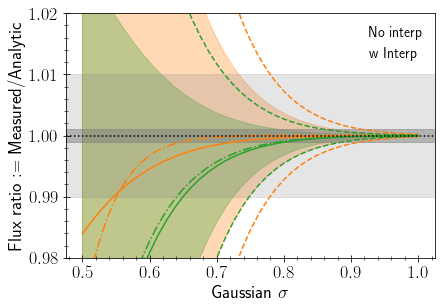

In [9]:
labels = ('No interp', 'w Interp')
fig, ax = plt.subplots()
#fig.set_size_inches([16,12])
for idx, flux in enumerate((adaptive, gaap)):

    color = color='C{}'.format(idx+1)
    ax.plot(sigmas, [np.mean(flux[ss]) for ss in sigmas], '-', color=color, label=labels[idx])
    ax.plot(sigmas, [np.percentile(flux[ss],50) for ss in sigmas], '-.', color=color,)
    ax.plot(sigmas, [np.min(flux[ss]) for ss in sigmas], '--', color=color,)
    ax.plot(sigmas, [np.max(flux[ss]) for ss in sigmas], '--', color=color,)
    ax.fill_between(sigmas, y1=[np.percentile(flux[ss],16) for ss in sigmas], y2=[np.percentile(flux[ss],84) for ss in sigmas], color=color, alpha=0.3)
    
#plt.errorbar(sigmas, np.mean(adaptive_flux), yerr=np.std(adaptive_flux), marker='s', color='C1', label='Adaptive (scaled)')
#plt.errorbar(sigmas, np.mean(gaap_flux), yerr=np.std(gaap_flux), marker='d', color='C2', label='GAaP (scaled)')
ax.axhline(1.0, color='k', ls=':')
ax.axhspan(ymin=0.99, ymax=1.01, color='gray', alpha=0.2)
ax.axhspan(ymin=0.999, ymax=1.001, color='gray', alpha=0.5)
ax.set_ylim(0.98,1.02)
ax.set_ylabel('Flux ratio := Measured/Analytic')
ax.set_xlabel(r'Gaussian $\sigma$')
_lgnd = ax.legend(loc=1)

In the plot above, the dotted lines denote the maximum and minimum ratios obtained as the sub-pixel offset is varied. The solid and the dashed-dotted lines denote the mean and the median values respectively. The shaded regions (in color) represent the 16-84 percentile region. The grey shaded regions denote 1% and 0.1% error in fluxes.

## Explanation

The inner product of two discrete images of size $N$ (total pixel counts) in real-space is related to the inner product of their DFTs as

$\sum_{\bf n} f[{\bf n}] g[{\bf n}] \equiv \frac{1}{N} \sum_{\bf k} \tilde{f}[{\bf k}] \tilde{g}[-{\bf k}]$


For any base band frequency ${\bf k}$

$\tilde{f}[k] = e^{-2\pi^2 {\bf k}^T C {\bf k}} e^{-i2\pi {\bf \delta}^T{\bf k}} + \sum_{\Delta} e^{-2\pi^2 ({\bf k}+{\bf \Delta})^T C ({\bf k} + {\bf \Delta})} e^{-i2\pi {\bf \delta}^T({\bf k}+{\bf \Delta})}$

$\tilde{g}[k] =  e^{-2\pi^2 {\bf k}^T C {\bf k}} e^{-i2\pi {\bf \delta}^T{\bf k}} $
 
For the sake of simplicity, let us denote

$\tilde{g}[k] = x$

and 

$\tilde{f}[k] = x + y$.



The phase of $x$ and $y$ are the only places where ${\delta}$ appears. In the generic case of $\delta \ne (0,0)$, $\sum_{\bf k} \tilde{f}[{\bf k}] \tilde{g}[-{\bf k}]$ is not guaranteed to be real, but it is sufficient to consider only the real part. We can justify this by conveniently redefining the top-hat function at the edge as 0.5, i.e., $\Pi(x) = 0.5$ if $|x| = 1/2$.

$\tilde{f}[k] \tilde{g}[-k] = x^*(x+y) = |x|^2 + x^*y \rightarrow |x|^2 + \mathbb{Re}(x^*y) $

$\tilde{f}[k] \tilde{f}[-k] = |x+y|^2 = |x|^2 + x^*y + xy^*  + |y|^2 \approx |x|^2 + 2\mathbb{Re}(x^*y)$


In the ideal case, the measured flux would simply be $|x|^2$, which is 1 after our rescaling. For $\delta=(0,0)$, both $x$ and $y$ are real and positive for all ${\bf k}$, and hence $\tilde{f}[k] \tilde{g}[-k] = |x|^2 + |x||y|$. However, no value of $\delta$ results in $|x|^2 - |x||y|$. This (and to some extent the presence of $|y|^2$ for $\tilde{f}[k] \tilde{f}[-k]$) makes the dependency on $\delta$ asymmetric, as seen by the extremities (dotted lines). The $\mathbb{Re}(x^*y)$ term can have either sign depending on the value of $\delta$. Despite the skew towards values $> |x|^2$, the region of space where the $\mathbb{Re}(x^*y)$ is negative is larger (see the plot below) making the average smaller than $|x|^2$. The factor $2$ is also roughly consistent with the observed fact that the sensitivity to $\delta$ for no-interpolation is roughly twice that when interpolation is done. As $\sigma$ increases, $|y|$ decreases rapidly and $\hat{F}$ converges to $|x|^2$. 

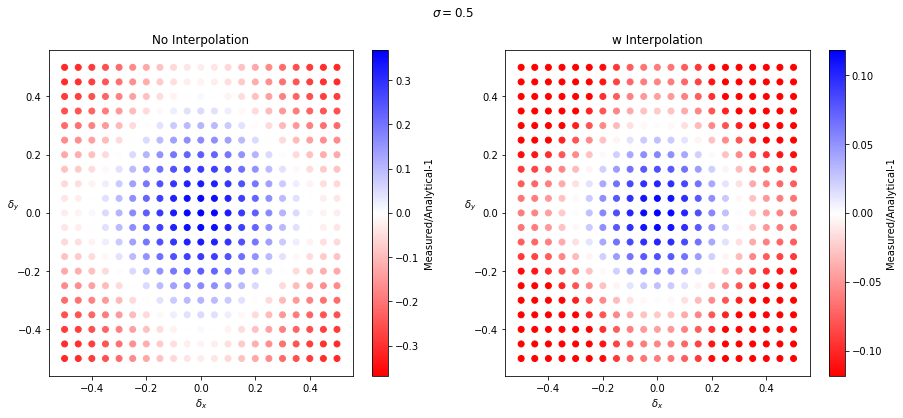

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches([15,6])
sigma = 0.5
X, Y = np.meshgrid(numpy.linspace(-0.5,0.5,21), numpy.arange(-0.5,0.5,21))

vmax = max(np.max(adaptive[sigma]), -np.min(adaptive[sigma]))-1
_im = ax[0].scatter(X,Y,c=np.array(adaptive[sigma]).reshape(X.shape)-1., cmap=cm.bwr_r, vmin=-vmax, vmax=vmax)
_cbar = fig.colorbar(_im, ax=ax[0])
_cbar.ax.set_ylabel('Measured/Analytical-1')
ax[0].set_title('No Interpolation')

vmax = max(np.max(gaap[sigma]), -np.min(gaap[sigma]))-1
_im = ax[1].scatter(X,Y,c=np.array(gaap[sigma]).reshape(X.shape)-1., cmap=cm.bwr_r, vmin=-vmax, vmax=vmax)
_cbar = fig.colorbar(_im, ax=ax[1])
_cbar.ax.set_ylabel('Measured/Analytical-1')
ax[1].set_title('w Interpolation')

fig.suptitle(r'$\sigma = {}$'.format(sigma))
for _ax in ax:
    _ax.set_xlabel(r'$\delta_x$')
    _ax.set_ylabel(r'$\delta_y$', rotation=0)
    

## Conclusion

The Gaussian fluxes could be guarateed to accurate to 0.1% for $\sigma \gtrsim 0.9$ pixels and with $1\sigma$ confidence for $\sigma \sim 0.85$ pixels. In practice, we do not expect to use such narrow Gaussian apertures. Even with the best of the best seeing, PSF FWHM are typically at least 2 pixels wide, which corresponds to $\sigma \approx 0.85$ pixels. For galaxy photometry, the size of the aperture is determined by the adaptive moments of the galaxy. For GAaP implementation, this size is larger than the worst seeing in a given filter. Thus, sampling Gaussians at pixel centers is accurate enough and is computationally less expensive than a sophisticated algorithm involving interpolation. 

Although we have not explicitly shown that our conclusion holds true when the image is non-Gaussian, since $W$ is designed to be a Gaussian, matched to the size of the galaxy (or at least the worst seeing PSF), the exact behaviour may vary a little but the effect is expected to be negligible for realistic values of $\sigma$. Even in the presence of pixel noise, the center pixel and $\sigma$ may themselves be biased. However, given the parameters of the Gaussian aperture, sampling the Gaussian at pixel centers is not expected to be worse than interpolating the pixel values.

---

However, in production code, interpolation within the pixels kicks in if $\sigma$ is less than half a pixel. So let us use the function we use in production to see how the errors vary as a function of $\sigma$.

In [2]:
import lsst.afw.image as afwImage
import lsst.meas.base as measBase

In [3]:
import numpy as np
np.array([2.5, 3.0, 4.0])*0.168

array([0.42 , 0.504, 0.672])